In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import PrintNNinfo as out
import os, subprocess
from time import time
from tqdm import tqdm
import pickle as pkl
from scipy.ndimage import gaussian_filter1d, gaussian_filter
# from scipy.signal import butter, lfilter, hilbert, resample
from scipy.interpolate import interp1d, interp2d
from scipy import signal
import multiprocessing
import pickle as pkl

In [2]:
def getFFT(x, dt, fmax=None, idt=None):
    if idt is not None:
        x = x[idt]
    n = len(x)
    fx = np.fft.fft(x, n) / n
    f = np.fft.fftfreq(n, dt)
    fx = abs(fx[:int(n//2)])
    f = f[:int(n//2)]
    if fmax is not None:
        idf = f < fmax
        f = f[idf]
        fx = fx[idf]
    return f, fx

def get_sync_index(vall, ind=None):
    # vall (:, n_cells)
    if ind is None:
        ind = np.ones(vall.shape[0], dtype=bool)
    
    v_avg = np.average(vall, axis=1)
    s_all = np.std(v_avg[ind])**2
    s_cell = np.std(vall[ind, :], axis=0)
    
    numer = np.average(s_all)
    denom = np.average(s_cell**2)
    
    return numer/denom

# Sync index

In [68]:
fdir = './result_ch/data'
fnames_tmp = os.listdir(fdir)
id_tags = [int(f.split('_')[1]) for f in fnames_tmp]
ind = np.argsort(id_tags)

fnames = []
for i in ind:
    fnames.append(fnames_tmp[i])

# load data
f_range = np.linspace(1, 201, 20)
gmax_range = np.linspace(5, 50, 20) #x1e-5

valls = []
tspks = []
si_maps = np.zeros([20, 20, 5])
f_maps = np.zeros([20, 20, 5])
fx_maps = np.zeros([20, 20, 5])

fnew = np.linspace(10, 200, 1000)

for n in tqdm(range(len(fnames))):
    f = fnames[n]
    
    m = n%400
    itr = n//400
    i = m//20
    j = m%20
    
    with open(os.path.join(fdir, f), 'rb') as fid:
        valls.append(pkl.load(fid))
        times = pkl.load(fid)
        
        tspks.append(pkl.load(fid))
        si_maps[i, j, itr] = pkl.load(fid)
    
    v_avg = np.average(valls[n], axis=1)
    
    f, fx = getFFT(v_avg, 0.01*1e-3)
    interp = interp1d(f[f>8], fx[f>8], kind='cubic')
    fxnew = interp(fnew)
    
    f_maps[i, j, itr] = fnew[fxnew == max(fxnew)]
    fx_maps[i, j, itr] = max(fxnew)


100%|██████████| 2000/2000 [00:41<00:00, 47.71it/s]


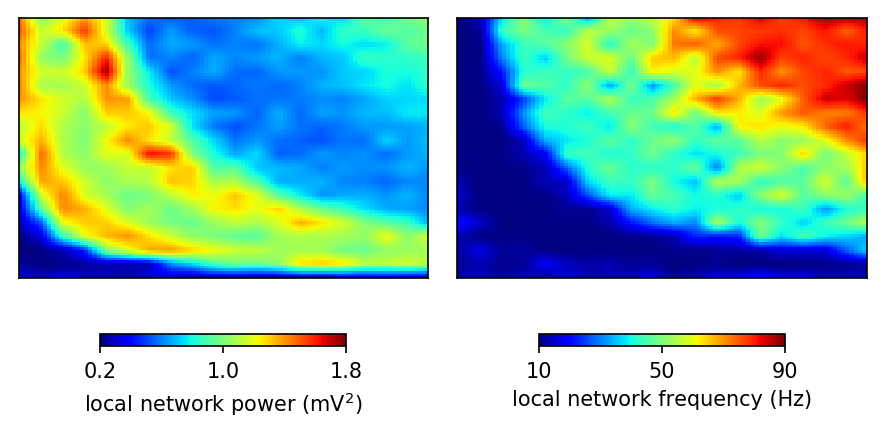

In [130]:
i = -1

X, Y = np.meshgrid(f_range, gmax_range)

fnew = np.linspace(f_range[0], f_range[-1], 100)
gnew = np.linspace(gmax_range[0], gmax_range[-1], 100)
Xnew, Ynew = np.meshgrid(fnew, gnew)

if i == -1:
#     interp = interp2d(f_range, gmax_range, np.average(si_maps, axis=2))
    interp = interp2d(f_range, gmax_range, np.average(fx_maps, axis=2))
    interp_f = interp2d(f_range, gmax_range, np.average(f_maps, axis=2))
else:
    interp = interp2d(f_range, gmax_range, si_maps[:, :, i])
    interp_f = interp2d(f_range, gmax_range, f_maps[:, :, i])

# interpolate

plt.figure(dpi=150, figsize=(6, 3))

plt.subplot(121)
options = {'cmap': 'jet'}

plt.pcolormesh(Xnew, Ynew, interp(fnew, gnew), **options, vmin=0.2, vmax=1.8)
cbar = plt.colorbar(shrink=0.6, orientation='horizontal')
cbar.set_ticks([0.2, 1, 1.8])
cbar.set_label(r'local network power (mV$^{2}$)')

# plt.xlabel("input frequency (Hz)", fontsize=12)
# plt.ylabel(r"$g_{max} (nS)$", fontsize=12)
plt.xticks([])
plt.yticks([])

plt.subplot(122)

plt.pcolormesh(Xnew, Ynew, interp_f(fnew, gnew), cmap='jet', vmax=90)
cbar = plt.colorbar(shrink=0.6, orientation='horizontal')
cbar.set_ticks([10, 50, 90])
cbar.set_label(r'local network frequency (Hz)')

# plt.xlabel("input frequency (Hz)", fontsize=12)
# plt.ylabel("gmax", fontsize=12)
plt.xticks([])
plt.yticks([])


plt.tight_layout()
plt.show()

85.211 Hz, 31.053, SI=0.057149
51.08108108108108 Hz


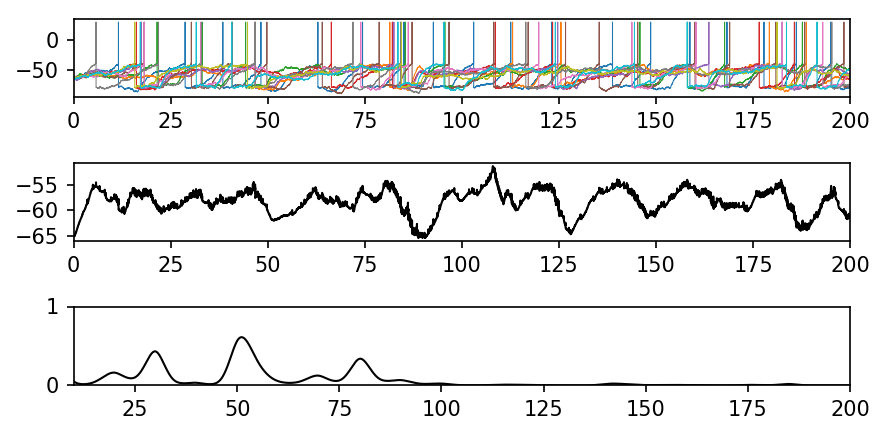

In [103]:
f = 80
g = 30
itr = 4

x = abs(f_range-f)
y = abs(gmax_range-g)
i = np.where(x == min(x))[0][0]
j = np.where(y == min(y))[0][0]
n = itr*400 + i*20 + j


print("%.3f Hz, %.3f, SI=%4f"%(f_range[i], gmax_range[j], si_maps[i, j, itr]))
fnew = np.linspace(10, 200, 1000)

plt.figure(dpi=150, figsize=(6, 3))

plt.subplot(311)
plt.plot(times, valls[n][:, :10], lw=0.5)
plt.xlim([0, 200])

plt.subplot(312)
v_avg = np.average(valls[n], axis=1)
plt.plot(times, v_avg, 'k', lw=1)
plt.xlim([0, 200])

plt.subplot(313)
f, fx = getFFT(v_avg, 0.01*1e-3)
interp = interp1d(f[f>8], fx[f>8], kind='cubic')
fxnew = interp(fnew)

plt.plot(fnew, fxnew**2, 'k', lw=1)
plt.xlim([10, 200])
plt.ylim([0, 1])

# print(fnew[fxnew == max(fxnew)][0], 'Hz')
print(f_maps[i, j, itr], 'Hz')

plt.tight_layout()
plt.show()

In [129]:
fnames[n]

'id_1771_f_085_ext_31-5_seed_36633.pkl'

# Test

# Result

In [131]:
fdir = './results/data'
fnames_tmp = os.listdir(fdir)
id_tags = [int(f.split('_')[1]) for f in fnames_tmp]
ind = np.argsort(id_tags)

fnames = []
for i in ind:
    fnames.append(fnames_tmp[i])

In [133]:
maps_si_bef = np.zeros([20, 20])
maps_si_aft = np.zeros([20, 20])

maps_bef_30 = np.zeros([20, 20])
maps_aft_30 = np.zeros([20, 20])

maps_bef_55 = np.zeros([20, 20])
maps_aft_55 = np.zeros([20, 20])

fx_befs = []
fx_afts = []
valls = []

for n in tqdm(range(len(fnames))):
    f = fnames[n]
# for n, f in enumerate(fnames):
    m = n%400
    
    i = int(n/400)
    j = int(m/20)
    k = m%20
    
    with open(os.path.join(fdir, f), 'rb') as fid:
        vall = pkl.load(fid)
        times = pkl.load(fid)
        
        fx_bef = pkl.load(fid)
        fx_aft = pkl.load(fid)    
        f_new = pkl.load(fid)
        
    valls.append(vall)
    
    
    ids_30 = (f_new>=25) & (f_new<=35) #[25, 35]
    ids_55 = (f_new>=50) & (f_new<=60) #[50, 60]
    
    # si
    maps_si_bef[j, k] += get_sync_index(vall, times<200)
    maps_si_aft[j, k] += get_sync_index(vall, times>=200)
    # f
    maps_bef_30[j, k] += np.average(fx_bef[ids_30])
    maps_aft_30[j, k] += np.average(fx_aft[ids_30])
    
    maps_bef_55[j, k] += np.average(fx_bef[ids_55])
    maps_aft_55[j, k] += np.average(fx_aft[ids_55])
    
    
    fx_befs.append(fx_bef)
    fx_afts.append(fx_aft)
    
maps_si_bef /= 5
maps_si_aft /= 5

maps_bef_30 /= 5
maps_aft_30 /= 5

maps_bef_55 /= 5
maps_aft_55 /= 5


100%|██████████| 2000/2000 [03:39<00:00,  9.10it/s]


In [184]:
peak_freq_map_bef = np.zeros([20, 20, 5])
peak_amp_map_bef = np.zeros([20, 20, 5])

peak_freq_map_aft = np.zeros([20, 20, 5])
peak_amp_map_aft = np.zeros([20, 20, 5])

for n in tqdm(range(len(fnames))):
    f = fnames[n]
    # for n, f in enumerate(fnames):
    m = n%400
    
    i = int(n/400)
    j = int(m/20)
    k = m%20
    
    ind = fx_befs[n] == max(fx_befs[n])
    peak_freq_map_bef[j, k, i] = f_new[ind]
    peak_amp_map_bef[j, k, i] = max(fx_befs[n])
    
    ind = fx_afts[n] == max(fx_afts[n])
    peak_freq_map_aft[j, k, i] = f_new[ind]
    peak_amp_map_aft[j, k, i] = max(fx_afts[n])
    
    
    

100%|██████████| 2000/2000 [00:00<00:00, 2957.09it/s]


In [185]:
gmax_to_pn_range = np.linspace(5, 50, 20) # x 1e-5
gmax_to_pv_range = np.linspace(5, 50, 20) # x 1e-5
X, Y = np.meshgrid(gmax_to_pn_range, gmax_to_pv_range)

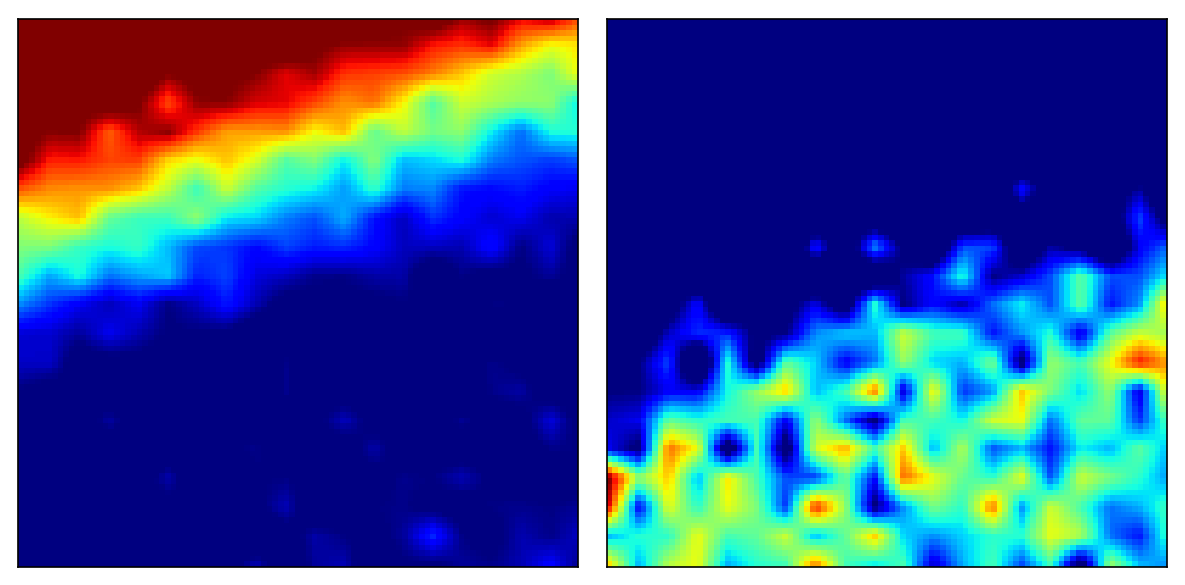

In [303]:
i = -1

gx = np.linspace(gmax_to_pn_range[0], gmax_to_pn_range[-1], 100)
gy = np.linspace(gmax_to_pv_range[0], gmax_to_pv_range[-1], 100)

if i == -1:
#     interp_freq = interp2d(gmax_to_pn_range, gmax_to_pv_range, np.median(peak_freq_map_bef, axis=2))
#     interp_amp = interp2d(gmax_to_pn_range, gmax_to_pv_range, np.average(peak_amp_map_bef, axis=2))
    interp_freq = interp2d(gmax_to_pn_range, gmax_to_pv_range, np.average(peak_freq_map_aft, axis=2))
    interp_amp = interp2d(gmax_to_pn_range, gmax_to_pv_range, np.average(peak_amp_map_aft, axis=2))
    
else:
#     interp_freq = interp2d(gmax_to_pn_range, gmax_to_pv_range, peak_freq_map_bef[:, :, i])
#     interp_amp = interp2d(gmax_to_pn_range, gmax_to_pv_range, peak_amp_map_bef[:, :, i])
    interp_freq = interp2d(gmax_to_pn_range, gmax_to_pv_range, peak_freq_map_aft[:, :, i])
    interp_amp = interp2d(gmax_to_pn_range, gmax_to_pv_range, peak_amp_map_aft[:, :, i])

Xnew, Ynew = np.meshgrid(gx, gy)


plt.figure(dpi=150, figsize=(8, 4))

# peak frequency map
plt.subplot(121)
options = {'cmap': 'jet', 'vmin': 1, 'vmax': 5}
plt.pcolormesh(Xnew, Ynew, gaussian_filter(interp_amp(gx, gy), 0)**2, **options)
# if i == -1:
#     plt.pcolormesh(X, Y, np.average(peak_freq_map, axis=2), **options)
# else:
#     plt.pcolormesh(X, Y, peak_freq_map[:, :, i], **options)
# plt.xlabel(r'g$_{exc}$', fontsize=12)
# plt.ylabel(r'g$_{inh}$', fontsize=12)
# plt.colorbar()
plt.xticks([])
plt.yticks([])


# peak amplitude map
plt.subplot(122)
options = {'cmap': 'jet', 'vmin': 30, 'vmax': 50}
plt.pcolormesh(Xnew, Ynew, gaussian_filter(interp_freq(gx, gy), 0.0), **options)
# if i == -1:
#     plt.pcolormesh(X, Y, np.average(peak_amp_map, axis=2), **options)
# else:
#     plt.pcolormesh(X, Y, peak_amp_map[:, :, i], **options)
# plt.xlabel(r'g$_{exc}$', fontsize=12)
# plt.ylabel(r'g$_{inh}$', fontsize=12)
# plt.colorbar()
plt.xticks([])
plt.yticks([])
    
plt.tight_layout()
plt.show()

## Result2

In [446]:
itr = 2
i = 15
j = 2

# itr = 2
# i = 2
# j = 16

n = 400*itr + 20*i + j
print(gmax_to_pn_range[i])
print(gmax_to_pv_range[j])

vall = valls[n]

40.526315789473685
9.736842105263158


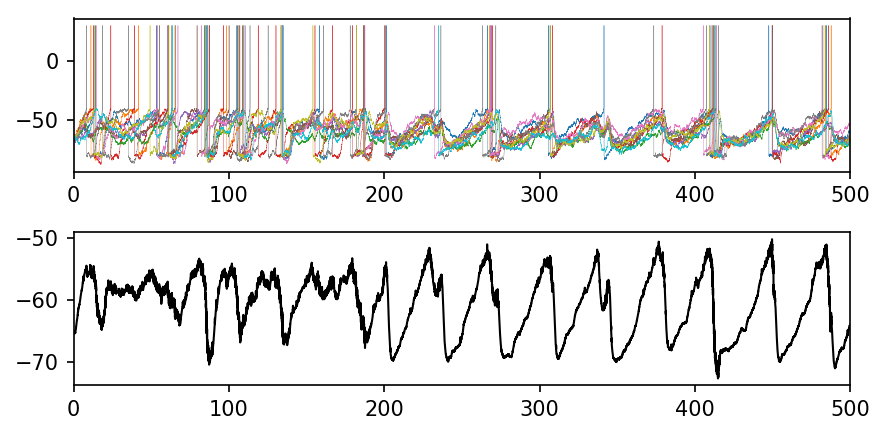

In [447]:
plt.figure(dpi=150, figsize=(6, 3))

plt.subplot(211)
plt.plot(times, vall[:, :10], lw=0.2)
plt.xlim([0, 500])

plt.subplot(212)
v_avg = np.average(vall, axis=1)
plt.plot(times, v_avg, 'k', lw=1)
plt.xlim([0, 500])

plt.tight_layout()
plt.show()

In [448]:
# idt = (times>200)&(times<500)
idt = times>200

mean_itvs = []
for i in range(vall.shape[1]):
    id_spk = vall[:, i] == 30
    tspk = times[idt&id_spk]
    if len(tspk) > 1:
        dtspk = np.average(1e3/(tspk[1:] - tspk[:-1]))
        mean_itvs.append(dtspk)
#         dtspk = 1e3/(tspk[1:] - tspk[:-1])
#         mean_itvs = np.concatenate((mean_itvs, dtspk))
    else:
        dtspk = -100
#     mean_itvs.append(dtspk)
print(np.median(mean_itvs))    

23.395580753833528


In [449]:
def set_lines(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

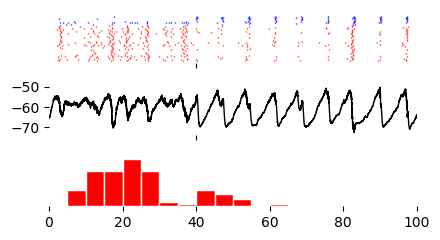

In [453]:
edges = np.arange(0, 100, 5)

plt.figure(dpi=100, figsize=(4.5, 2.5))

ax1 = plt.subplot(311)
for i in range(n_cells):
    if i < 100:
        c = 'r'
    else:
        c = 'b'
    tspk = times[vall[:, i] == 30]
    plt.vlines(tspk, i-0.5, i+0.5, color=c, lw=1)
set_lines(ax1)
plt.xlim([0, 500])
plt.xticks([200], [''])
plt.yticks([])

ax2 = plt.subplot(312)
plt.plot(times, np.average(vall, axis=1), 'k', lw=1)
set_lines(ax2)
plt.xlim([0, 500])
plt.xticks([200], [''])
# plt.yticks([])


ax3 = plt.subplot(313)
plt.hist(mean_itvs, edges, fc='r', ec='w')
set_lines(ax3)
plt.xlim([0, 100])
# plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

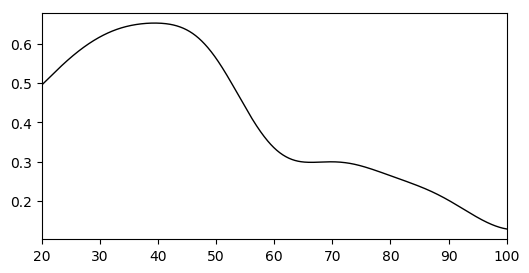

In [409]:
f, fx = getFFT(v_avg[idt], 0.01*1e-3)
idf = (f>10)&(f<100)
f = f[idf]
fx = fx[idf]

fnew = np.linspace(f[0], f[-1], 1000)
y = gaussian_filter(fx, 2)
interp = interp1d(f, y, kind='cubic')
ynew = interp(fnew)

plt.figure(dpi=100, figsize=(6, 3))
plt.plot(fnew, ynew, 'k', lw=1)
plt.xlim([20, 100])

plt.show()


In [151]:
itv_maps = np.zeros([20, 20, 5])
idt = (times>200)&(times<500)
n_cells = 125

for n in tqdm(range(2000)):
    m = n%400
    
    itr = n // 400
    i = m // 20
    j = m % 20
    
    id_spks = valls[n] == 30
    itvs = []
    
    for k in range(n_cells):
        tspk = times[idt&id_spks[:, k]]
        
        if len(tspk) > 1:
            dtspk = np.average(1e3/(tspk[1:] - tspk[:-1]))
            itvs.append(dtspk)
    
    itv_maps[i, j, itr] = np.median(itvs)
        
    

100%|██████████| 2000/2000 [01:21<00:00, 24.65it/s]


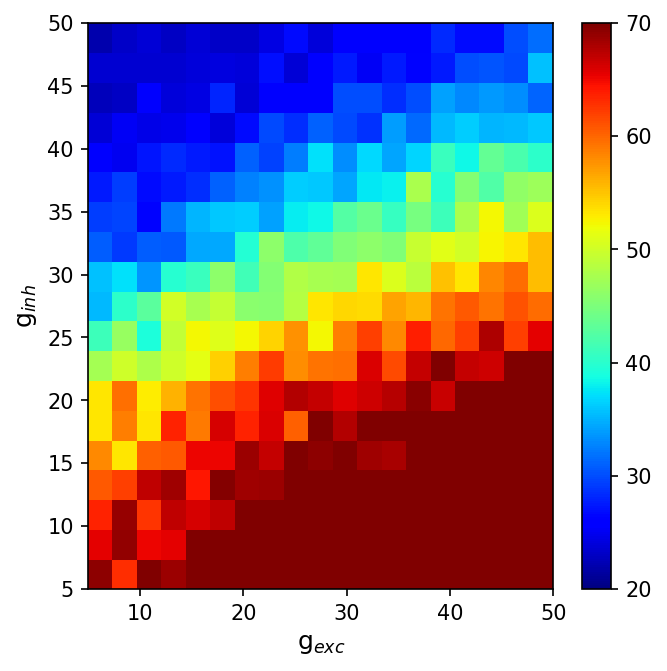

In [153]:
X, Y = np.meshgrid(gmax_to_pn_range, gmax_to_pv_range)

plt.figure(dpi=150, figsize=(5, 5))
# plt.imshow(itv_maps[:, :, 1], cmap='jet', vmin=30, vmax=60)
# plt.imshow(np.average(itv_maps, axis=2), cmap='jet')
# plt.pcolormesh(X, Y, itv_maps[:, :, 1], cmap='jet', vmin=30, vmax=60)
plt.pcolormesh(X, Y, np.average(itv_maps, axis=2), cmap='jet', vmin=20, vmax=70)
plt.xlabel(r'g$_{exc}$', fontsize=12)
plt.ylabel(r'g$_{inh}$', fontsize=12)
plt.colorbar()
plt.show()

NameError: name 'im30' is not defined

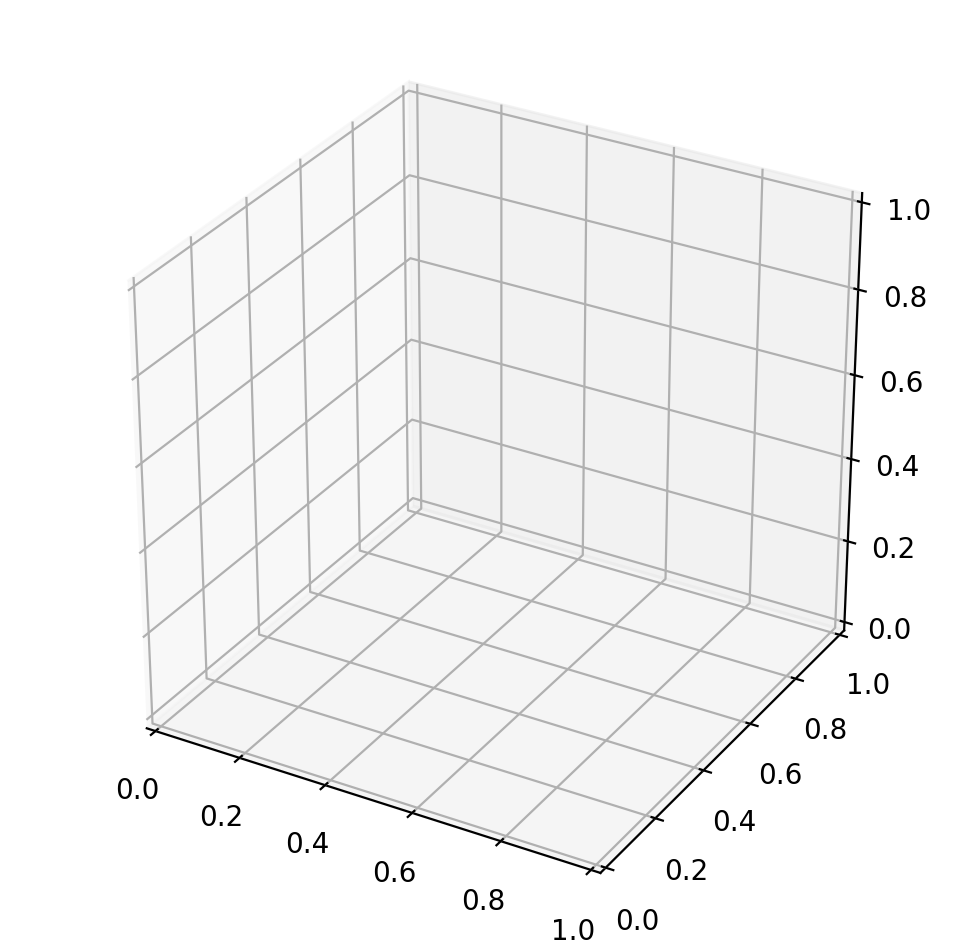

In [199]:
from mpl_toolkits import mplot3d

fig = plt.figure(dpi=200, figsize=(6,6))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, im30**2, color='r', alpha=0.8)
ax.plot_surface(X, Y, im55**2, color='b', alpha=0.8)

plt.xlabel('gmax_pfc_to_pn')
plt.ylabel('gmax_pfc_to_pv')
ax.set_zlabel('mean_power')

plt.tight_layout()
plt.show()